# Convolutional Autoencoder using pytorch
Following the example from: <br>
https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [2]:
# please specify data path
datapath = '../data/MNIST/raw'

### Import MNIST dataset and prepare data

In [3]:
train_dataset = torchvision.datasets.MNIST(datapath, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(datapath, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw/MNIST/raw

Processing...
Done!


/home/yangliu/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Define convolutional autoencoder
It will be composed of two classes: one for the encoder and one for the decoder. The encoder will contain three convolutional layers and two fully connected layers. Some batch norm layers are added as regularizers. The decoder will have the same architecture but in inverse order.

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [7]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [8]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [9]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253419
	 partial train loss (single batch): 0.246293
	 partial train loss (single batch): 0.240600
	 partial train loss (single batch): 0.235949
	 partial train loss (single batch): 0.232309
	 partial train loss (single batch): 0.228212
	 partial train loss (single batch): 0.225066
	 partial train loss (single batch): 0.222068
	 partial train loss (single batch): 0.219749
	 partial train loss (single batch): 0.217210
	 partial train loss (single batch): 0.215852
	 partial train loss (single batch): 0.213376
	 partial train loss (single batch): 0.211231
	 partial train loss (single batch): 0.209267
	 partial train loss (single batch): 0.207082
	 partial train loss (single batch): 0.205372
	 partial train loss (single batch): 0.203027
	 partial train loss (single batch): 0.201061
	 partial train loss (single batch): 0.199168
	 partial train loss (single batch): 0.197585
	 partial train loss (single batch): 0.195797
	 partial train loss (single batch

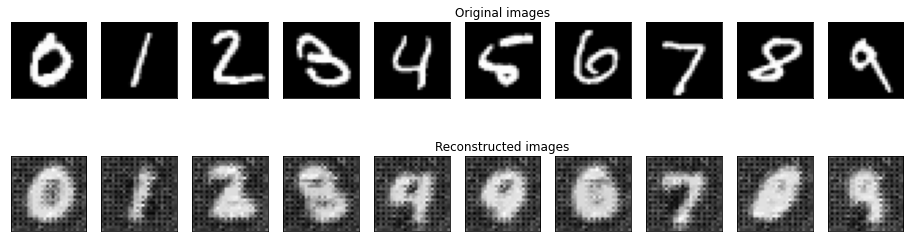

	 partial train loss (single batch): 0.065191
	 partial train loss (single batch): 0.064296
	 partial train loss (single batch): 0.065456
	 partial train loss (single batch): 0.065744
	 partial train loss (single batch): 0.064146
	 partial train loss (single batch): 0.064140
	 partial train loss (single batch): 0.064512
	 partial train loss (single batch): 0.064608
	 partial train loss (single batch): 0.063719
	 partial train loss (single batch): 0.064412
	 partial train loss (single batch): 0.062719
	 partial train loss (single batch): 0.064136
	 partial train loss (single batch): 0.062931
	 partial train loss (single batch): 0.062709
	 partial train loss (single batch): 0.063508
	 partial train loss (single batch): 0.062371
	 partial train loss (single batch): 0.061007
	 partial train loss (single batch): 0.060646
	 partial train loss (single batch): 0.061663
	 partial train loss (single batch): 0.060996
	 partial train loss (single batch): 0.062249
	 partial train loss (single batch

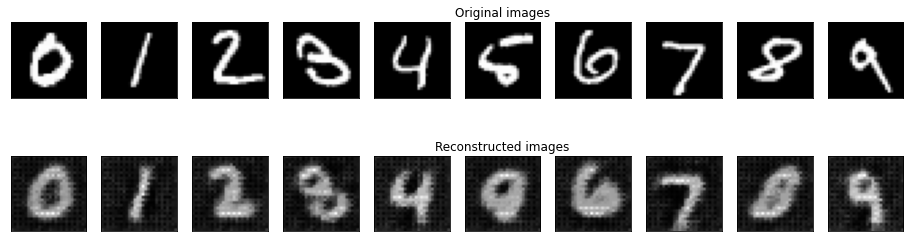

	 partial train loss (single batch): 0.045698
	 partial train loss (single batch): 0.044830
	 partial train loss (single batch): 0.046503
	 partial train loss (single batch): 0.047221
	 partial train loss (single batch): 0.044864
	 partial train loss (single batch): 0.045578
	 partial train loss (single batch): 0.045846
	 partial train loss (single batch): 0.046423
	 partial train loss (single batch): 0.046040
	 partial train loss (single batch): 0.046779
	 partial train loss (single batch): 0.044801
	 partial train loss (single batch): 0.046919
	 partial train loss (single batch): 0.045561
	 partial train loss (single batch): 0.045163
	 partial train loss (single batch): 0.046659
	 partial train loss (single batch): 0.045454
	 partial train loss (single batch): 0.044057
	 partial train loss (single batch): 0.043789
	 partial train loss (single batch): 0.045159
	 partial train loss (single batch): 0.044529
	 partial train loss (single batch): 0.045901
	 partial train loss (single batch

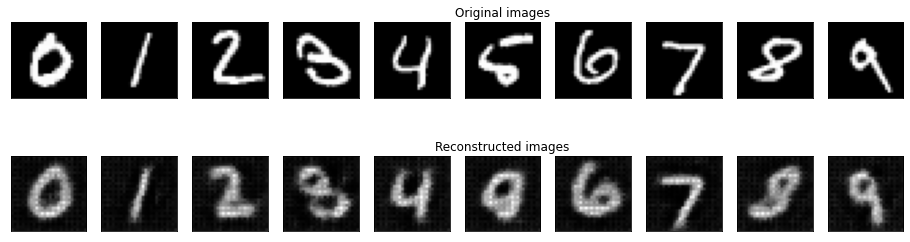

	 partial train loss (single batch): 0.037428
	 partial train loss (single batch): 0.036334
	 partial train loss (single batch): 0.037646
	 partial train loss (single batch): 0.039150
	 partial train loss (single batch): 0.036246
	 partial train loss (single batch): 0.036820
	 partial train loss (single batch): 0.037636
	 partial train loss (single batch): 0.037405
	 partial train loss (single batch): 0.037884
	 partial train loss (single batch): 0.038882
	 partial train loss (single batch): 0.036569
	 partial train loss (single batch): 0.038598
	 partial train loss (single batch): 0.037528
	 partial train loss (single batch): 0.036813
	 partial train loss (single batch): 0.038161
	 partial train loss (single batch): 0.036839
	 partial train loss (single batch): 0.036031
	 partial train loss (single batch): 0.035513
	 partial train loss (single batch): 0.036563
	 partial train loss (single batch): 0.036752
	 partial train loss (single batch): 0.037301
	 partial train loss (single batch

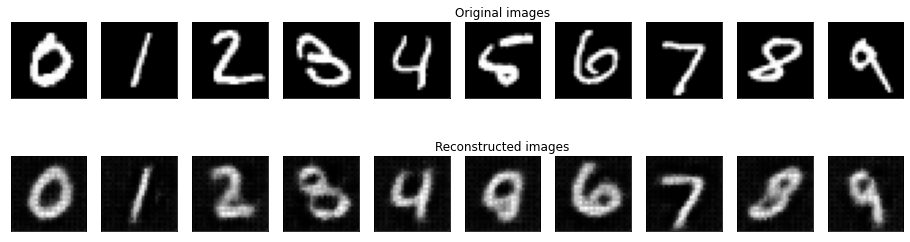

	 partial train loss (single batch): 0.032992
	 partial train loss (single batch): 0.032387
	 partial train loss (single batch): 0.033360
	 partial train loss (single batch): 0.035246
	 partial train loss (single batch): 0.032068
	 partial train loss (single batch): 0.032469
	 partial train loss (single batch): 0.033588
	 partial train loss (single batch): 0.033183
	 partial train loss (single batch): 0.033926
	 partial train loss (single batch): 0.034871
	 partial train loss (single batch): 0.032840
	 partial train loss (single batch): 0.034584
	 partial train loss (single batch): 0.033627
	 partial train loss (single batch): 0.032546
	 partial train loss (single batch): 0.034062
	 partial train loss (single batch): 0.032920
	 partial train loss (single batch): 0.031889
	 partial train loss (single batch): 0.031720
	 partial train loss (single batch): 0.032574
	 partial train loss (single batch): 0.032854
	 partial train loss (single batch): 0.033346
	 partial train loss (single batch

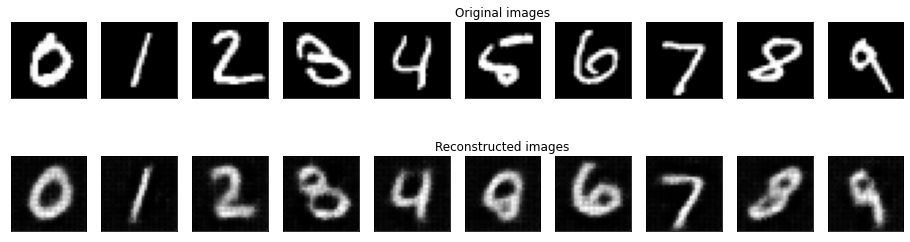

	 partial train loss (single batch): 0.031254
	 partial train loss (single batch): 0.030452
	 partial train loss (single batch): 0.031391
	 partial train loss (single batch): 0.033420
	 partial train loss (single batch): 0.029897
	 partial train loss (single batch): 0.030543
	 partial train loss (single batch): 0.031691
	 partial train loss (single batch): 0.031133
	 partial train loss (single batch): 0.032196
	 partial train loss (single batch): 0.032863
	 partial train loss (single batch): 0.030873
	 partial train loss (single batch): 0.032878
	 partial train loss (single batch): 0.031716
	 partial train loss (single batch): 0.030651
	 partial train loss (single batch): 0.032223
	 partial train loss (single batch): 0.030887
	 partial train loss (single batch): 0.029911
	 partial train loss (single batch): 0.029913
	 partial train loss (single batch): 0.030501
	 partial train loss (single batch): 0.031183
	 partial train loss (single batch): 0.031608
	 partial train loss (single batch

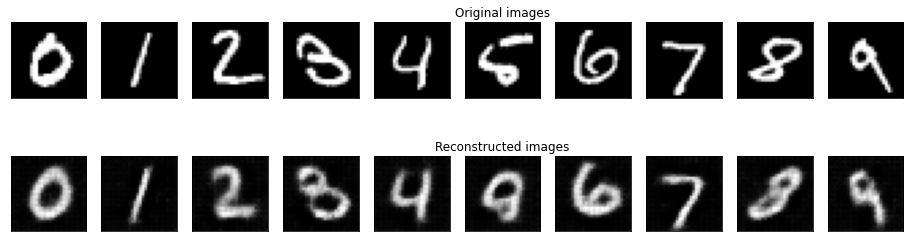

	 partial train loss (single batch): 0.029971
	 partial train loss (single batch): 0.029323
	 partial train loss (single batch): 0.030346
	 partial train loss (single batch): 0.032330
	 partial train loss (single batch): 0.028766
	 partial train loss (single batch): 0.029516
	 partial train loss (single batch): 0.030709
	 partial train loss (single batch): 0.030062
	 partial train loss (single batch): 0.031264
	 partial train loss (single batch): 0.031924
	 partial train loss (single batch): 0.029592
	 partial train loss (single batch): 0.031882
	 partial train loss (single batch): 0.030675
	 partial train loss (single batch): 0.029628
	 partial train loss (single batch): 0.031214
	 partial train loss (single batch): 0.029788
	 partial train loss (single batch): 0.028971
	 partial train loss (single batch): 0.029049
	 partial train loss (single batch): 0.029386
	 partial train loss (single batch): 0.030158
	 partial train loss (single batch): 0.030719
	 partial train loss (single batch

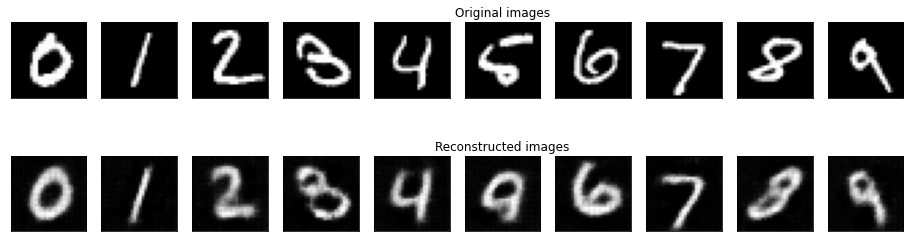

	 partial train loss (single batch): 0.029239
	 partial train loss (single batch): 0.028662
	 partial train loss (single batch): 0.029689
	 partial train loss (single batch): 0.031572
	 partial train loss (single batch): 0.028074
	 partial train loss (single batch): 0.028703
	 partial train loss (single batch): 0.030003
	 partial train loss (single batch): 0.029378
	 partial train loss (single batch): 0.030627
	 partial train loss (single batch): 0.031245
	 partial train loss (single batch): 0.028934
	 partial train loss (single batch): 0.031166
	 partial train loss (single batch): 0.029919
	 partial train loss (single batch): 0.028956
	 partial train loss (single batch): 0.030605
	 partial train loss (single batch): 0.029015
	 partial train loss (single batch): 0.028318
	 partial train loss (single batch): 0.028528
	 partial train loss (single batch): 0.028621
	 partial train loss (single batch): 0.029367
	 partial train loss (single batch): 0.030229
	 partial train loss (single batch

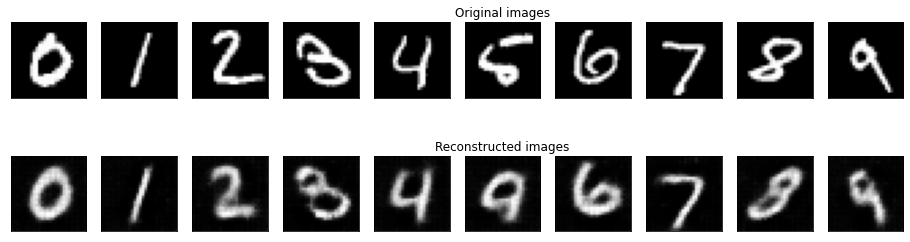

	 partial train loss (single batch): 0.028698
	 partial train loss (single batch): 0.028069
	 partial train loss (single batch): 0.029154
	 partial train loss (single batch): 0.031088
	 partial train loss (single batch): 0.027491
	 partial train loss (single batch): 0.028182
	 partial train loss (single batch): 0.029515
	 partial train loss (single batch): 0.028914
	 partial train loss (single batch): 0.030154
	 partial train loss (single batch): 0.030676
	 partial train loss (single batch): 0.028339
	 partial train loss (single batch): 0.030493
	 partial train loss (single batch): 0.029301
	 partial train loss (single batch): 0.028435
	 partial train loss (single batch): 0.029993
	 partial train loss (single batch): 0.028465
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.028031
	 partial train loss (single batch): 0.028039
	 partial train loss (single batch): 0.028869
	 partial train loss (single batch): 0.029850
	 partial train loss (single batch

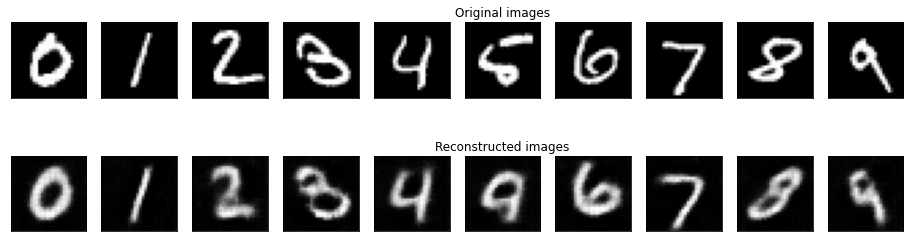

	 partial train loss (single batch): 0.028298
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.028776
	 partial train loss (single batch): 0.030595
	 partial train loss (single batch): 0.027084
	 partial train loss (single batch): 0.027799
	 partial train loss (single batch): 0.029128
	 partial train loss (single batch): 0.028561
	 partial train loss (single batch): 0.029788
	 partial train loss (single batch): 0.030218
	 partial train loss (single batch): 0.027966
	 partial train loss (single batch): 0.030075
	 partial train loss (single batch): 0.028917
	 partial train loss (single batch): 0.027995
	 partial train loss (single batch): 0.029596
	 partial train loss (single batch): 0.028153
	 partial train loss (single batch): 0.027342
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.027505
	 partial train loss (single batch): 0.028530
	 partial train loss (single batch): 0.029378
	 partial train loss (single batch

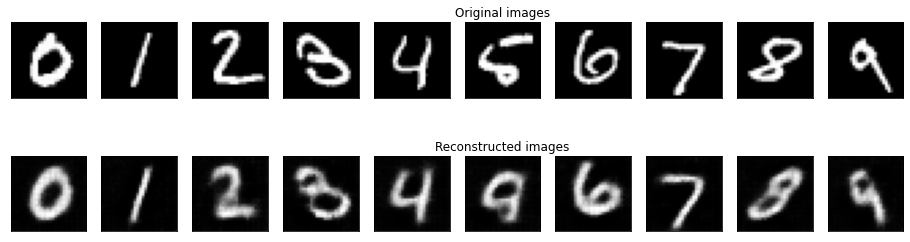

	 partial train loss (single batch): 0.027943
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.028486
	 partial train loss (single batch): 0.030307
	 partial train loss (single batch): 0.026630
	 partial train loss (single batch): 0.027565
	 partial train loss (single batch): 0.028774
	 partial train loss (single batch): 0.028285
	 partial train loss (single batch): 0.029493
	 partial train loss (single batch): 0.029829
	 partial train loss (single batch): 0.027633
	 partial train loss (single batch): 0.029636
	 partial train loss (single batch): 0.028588
	 partial train loss (single batch): 0.027667
	 partial train loss (single batch): 0.029320
	 partial train loss (single batch): 0.027922
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.027296
	 partial train loss (single batch): 0.027168
	 partial train loss (single batch): 0.028195
	 partial train loss (single batch): 0.029078
	 partial train loss (single batch

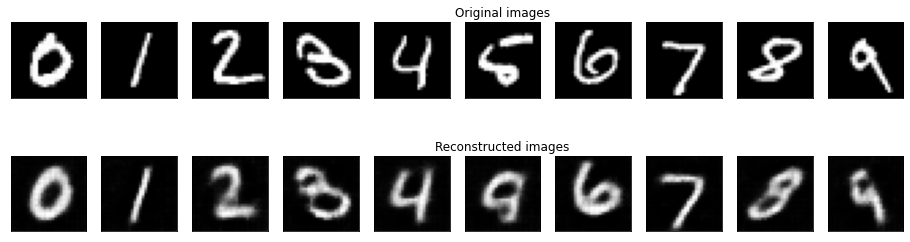

	 partial train loss (single batch): 0.027641
	 partial train loss (single batch): 0.027105
	 partial train loss (single batch): 0.028332
	 partial train loss (single batch): 0.030059
	 partial train loss (single batch): 0.026251
	 partial train loss (single batch): 0.027366
	 partial train loss (single batch): 0.028490
	 partial train loss (single batch): 0.028016
	 partial train loss (single batch): 0.029198
	 partial train loss (single batch): 0.029546
	 partial train loss (single batch): 0.027396
	 partial train loss (single batch): 0.029323
	 partial train loss (single batch): 0.028260
	 partial train loss (single batch): 0.027330
	 partial train loss (single batch): 0.029040
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.026831
	 partial train loss (single batch): 0.026990
	 partial train loss (single batch): 0.026800
	 partial train loss (single batch): 0.027867
	 partial train loss (single batch): 0.028788
	 partial train loss (single batch

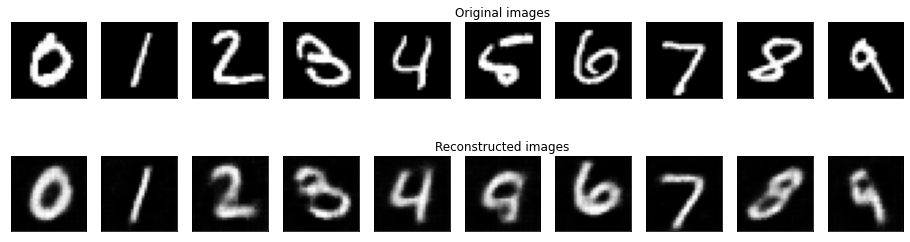

	 partial train loss (single batch): 0.027427
	 partial train loss (single batch): 0.026845
	 partial train loss (single batch): 0.028125
	 partial train loss (single batch): 0.029874
	 partial train loss (single batch): 0.025945
	 partial train loss (single batch): 0.027124
	 partial train loss (single batch): 0.028241
	 partial train loss (single batch): 0.027768
	 partial train loss (single batch): 0.028879
	 partial train loss (single batch): 0.029209
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.029003
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch): 0.027141
	 partial train loss (single batch): 0.028763
	 partial train loss (single batch): 0.027418
	 partial train loss (single batch): 0.026551
	 partial train loss (single batch): 0.026837
	 partial train loss (single batch): 0.026567
	 partial train loss (single batch): 0.027695
	 partial train loss (single batch): 0.028559
	 partial train loss (single batch

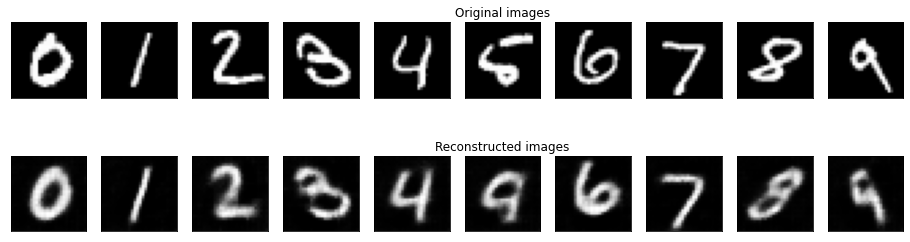

	 partial train loss (single batch): 0.027359
	 partial train loss (single batch): 0.026626
	 partial train loss (single batch): 0.027968
	 partial train loss (single batch): 0.029712
	 partial train loss (single batch): 0.025729
	 partial train loss (single batch): 0.026909
	 partial train loss (single batch): 0.027931
	 partial train loss (single batch): 0.027586
	 partial train loss (single batch): 0.028657
	 partial train loss (single batch): 0.028986
	 partial train loss (single batch): 0.027072
	 partial train loss (single batch): 0.028741
	 partial train loss (single batch): 0.027745
	 partial train loss (single batch): 0.027027
	 partial train loss (single batch): 0.028616
	 partial train loss (single batch): 0.027160
	 partial train loss (single batch): 0.026375
	 partial train loss (single batch): 0.026660
	 partial train loss (single batch): 0.026443
	 partial train loss (single batch): 0.027580
	 partial train loss (single batch): 0.028370
	 partial train loss (single batch

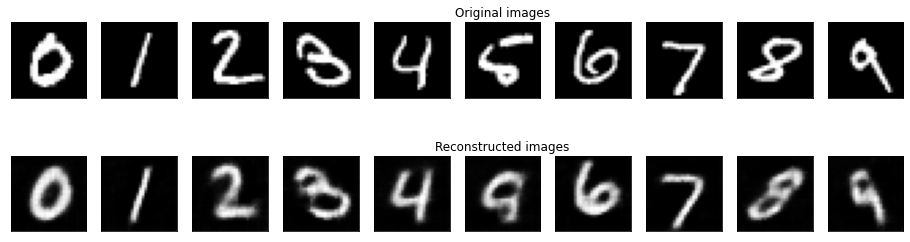

	 partial train loss (single batch): 0.027185
	 partial train loss (single batch): 0.026492
	 partial train loss (single batch): 0.027761
	 partial train loss (single batch): 0.029534
	 partial train loss (single batch): 0.025547
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.027782
	 partial train loss (single batch): 0.027439
	 partial train loss (single batch): 0.028494
	 partial train loss (single batch): 0.028749
	 partial train loss (single batch): 0.026864
	 partial train loss (single batch): 0.028509
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.026916
	 partial train loss (single batch): 0.028454
	 partial train loss (single batch): 0.026923
	 partial train loss (single batch): 0.026228
	 partial train loss (single batch): 0.026527
	 partial train loss (single batch): 0.026297
	 partial train loss (single batch): 0.027396
	 partial train loss (single batch): 0.028188
	 partial train loss (single batch

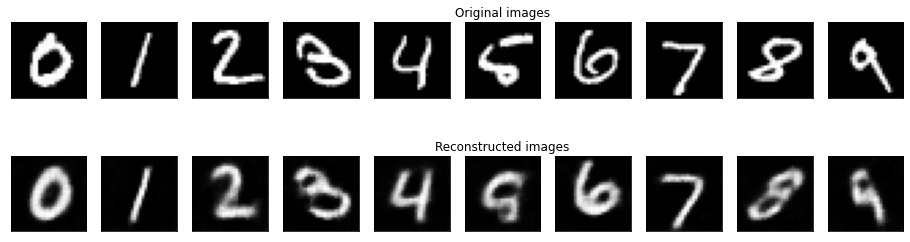

	 partial train loss (single batch): 0.026956
	 partial train loss (single batch): 0.026420
	 partial train loss (single batch): 0.027611
	 partial train loss (single batch): 0.029327
	 partial train loss (single batch): 0.025418
	 partial train loss (single batch): 0.026545
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.027220
	 partial train loss (single batch): 0.028270
	 partial train loss (single batch): 0.028627
	 partial train loss (single batch): 0.026666
	 partial train loss (single batch): 0.028418
	 partial train loss (single batch): 0.027188
	 partial train loss (single batch): 0.026770
	 partial train loss (single batch): 0.028328
	 partial train loss (single batch): 0.026690
	 partial train loss (single batch): 0.026091
	 partial train loss (single batch): 0.026406
	 partial train loss (single batch): 0.026182
	 partial train loss (single batch): 0.027273
	 partial train loss (single batch): 0.028032
	 partial train loss (single batch

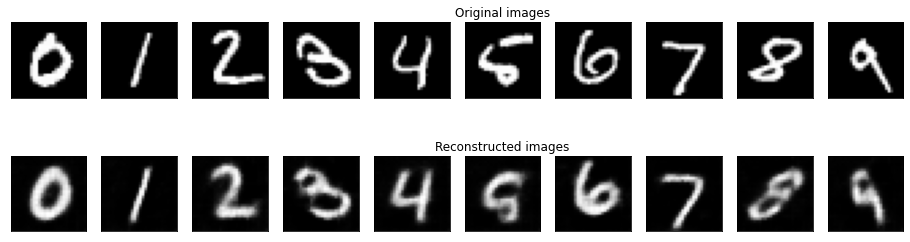

	 partial train loss (single batch): 0.026761
	 partial train loss (single batch): 0.026298
	 partial train loss (single batch): 0.027433
	 partial train loss (single batch): 0.029154
	 partial train loss (single batch): 0.025294
	 partial train loss (single batch): 0.026404
	 partial train loss (single batch): 0.027485
	 partial train loss (single batch): 0.027072
	 partial train loss (single batch): 0.028049
	 partial train loss (single batch): 0.028486
	 partial train loss (single batch): 0.026538
	 partial train loss (single batch): 0.028350
	 partial train loss (single batch): 0.027078
	 partial train loss (single batch): 0.026635
	 partial train loss (single batch): 0.028237
	 partial train loss (single batch): 0.026486
	 partial train loss (single batch): 0.025882
	 partial train loss (single batch): 0.026306
	 partial train loss (single batch): 0.026037
	 partial train loss (single batch): 0.027143
	 partial train loss (single batch): 0.027932
	 partial train loss (single batch

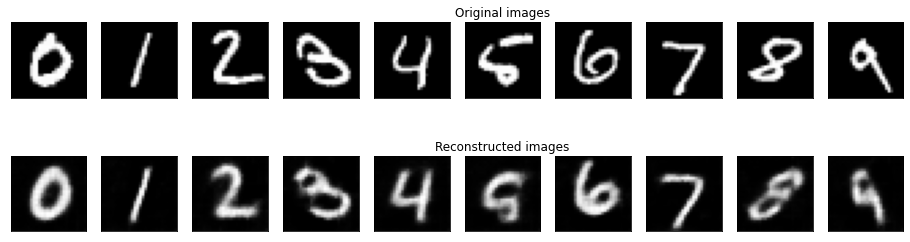

	 partial train loss (single batch): 0.026548
	 partial train loss (single batch): 0.026147
	 partial train loss (single batch): 0.027305
	 partial train loss (single batch): 0.028962
	 partial train loss (single batch): 0.025228
	 partial train loss (single batch): 0.026228
	 partial train loss (single batch): 0.027334
	 partial train loss (single batch): 0.026868
	 partial train loss (single batch): 0.027877
	 partial train loss (single batch): 0.028344
	 partial train loss (single batch): 0.026406
	 partial train loss (single batch): 0.028218
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.026498
	 partial train loss (single batch): 0.028161
	 partial train loss (single batch): 0.026352
	 partial train loss (single batch): 0.025719
	 partial train loss (single batch): 0.026134
	 partial train loss (single batch): 0.025876
	 partial train loss (single batch): 0.026921
	 partial train loss (single batch): 0.027944
	 partial train loss (single batch

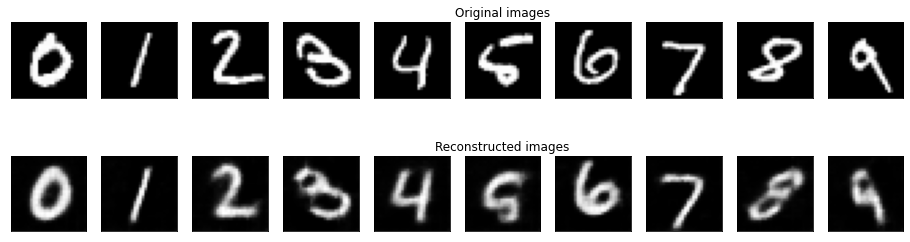

	 partial train loss (single batch): 0.026445
	 partial train loss (single batch): 0.026063
	 partial train loss (single batch): 0.027225
	 partial train loss (single batch): 0.028824
	 partial train loss (single batch): 0.025071
	 partial train loss (single batch): 0.026203
	 partial train loss (single batch): 0.027137
	 partial train loss (single batch): 0.026834
	 partial train loss (single batch): 0.027766
	 partial train loss (single batch): 0.028256
	 partial train loss (single batch): 0.026348
	 partial train loss (single batch): 0.028149
	 partial train loss (single batch): 0.026880
	 partial train loss (single batch): 0.026483
	 partial train loss (single batch): 0.028051
	 partial train loss (single batch): 0.026155
	 partial train loss (single batch): 0.025608
	 partial train loss (single batch): 0.026019
	 partial train loss (single batch): 0.025847
	 partial train loss (single batch): 0.026707
	 partial train loss (single batch): 0.027841
	 partial train loss (single batch

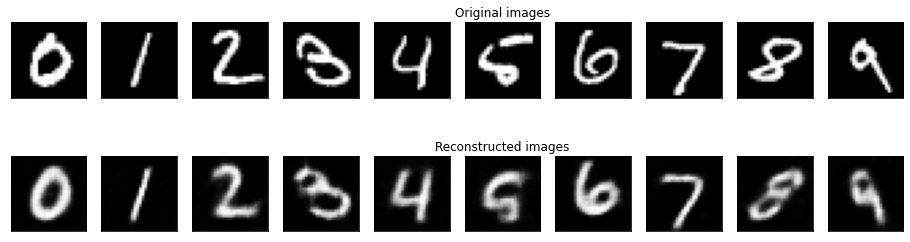

	 partial train loss (single batch): 0.026315
	 partial train loss (single batch): 0.025966
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.028831
	 partial train loss (single batch): 0.025004
	 partial train loss (single batch): 0.026019
	 partial train loss (single batch): 0.026995
	 partial train loss (single batch): 0.026682
	 partial train loss (single batch): 0.027545
	 partial train loss (single batch): 0.028110
	 partial train loss (single batch): 0.026208
	 partial train loss (single batch): 0.028011
	 partial train loss (single batch): 0.026721
	 partial train loss (single batch): 0.026331
	 partial train loss (single batch): 0.027901
	 partial train loss (single batch): 0.026000
	 partial train loss (single batch): 0.025498
	 partial train loss (single batch): 0.025922
	 partial train loss (single batch): 0.025670
	 partial train loss (single batch): 0.026484
	 partial train loss (single batch): 0.027674
	 partial train loss (single batch

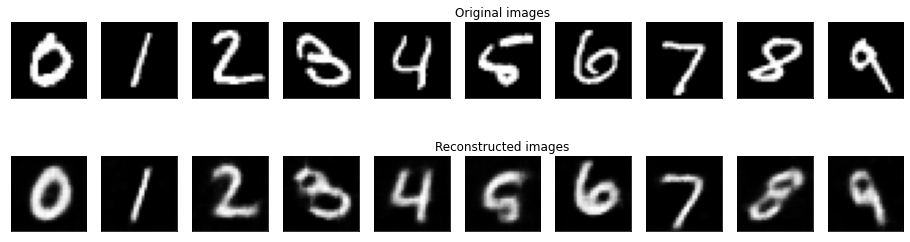

	 partial train loss (single batch): 0.026137
	 partial train loss (single batch): 0.025799
	 partial train loss (single batch): 0.027015
	 partial train loss (single batch): 0.028700
	 partial train loss (single batch): 0.024843
	 partial train loss (single batch): 0.025895
	 partial train loss (single batch): 0.026802
	 partial train loss (single batch): 0.026616
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.027933
	 partial train loss (single batch): 0.026055
	 partial train loss (single batch): 0.027885
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.026272
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.025775
	 partial train loss (single batch): 0.025323
	 partial train loss (single batch): 0.025754
	 partial train loss (single batch): 0.025560
	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.027616
	 partial train loss (single batch

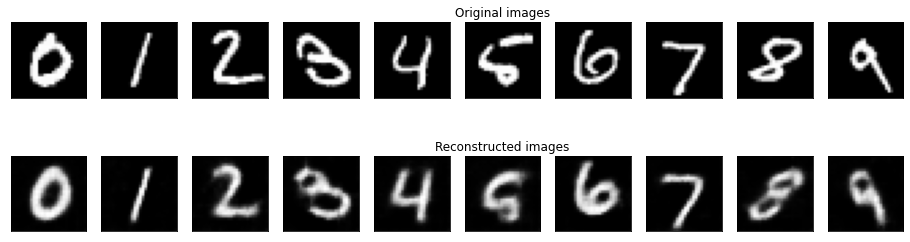

	 partial train loss (single batch): 0.026001
	 partial train loss (single batch): 0.025630
	 partial train loss (single batch): 0.026909
	 partial train loss (single batch): 0.028594
	 partial train loss (single batch): 0.024727
	 partial train loss (single batch): 0.025871
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.026481
	 partial train loss (single batch): 0.027272
	 partial train loss (single batch): 0.027733
	 partial train loss (single batch): 0.025905
	 partial train loss (single batch): 0.027761
	 partial train loss (single batch): 0.026501
	 partial train loss (single batch): 0.026124
	 partial train loss (single batch): 0.027547
	 partial train loss (single batch): 0.025635
	 partial train loss (single batch): 0.025314
	 partial train loss (single batch): 0.025625
	 partial train loss (single batch): 0.025362
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.027528
	 partial train loss (single batch

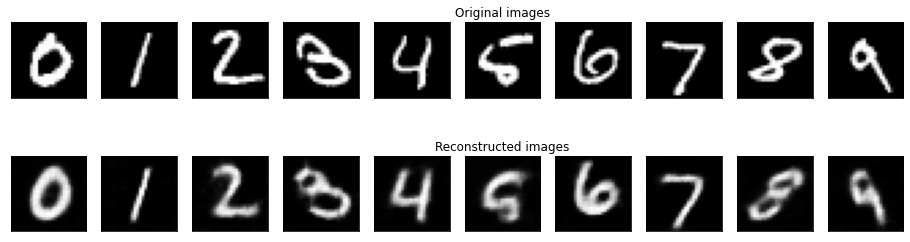

	 partial train loss (single batch): 0.025908
	 partial train loss (single batch): 0.025574
	 partial train loss (single batch): 0.026816
	 partial train loss (single batch): 0.028516
	 partial train loss (single batch): 0.024652
	 partial train loss (single batch): 0.025688
	 partial train loss (single batch): 0.026542
	 partial train loss (single batch): 0.026370
	 partial train loss (single batch): 0.027214
	 partial train loss (single batch): 0.027648
	 partial train loss (single batch): 0.025736
	 partial train loss (single batch): 0.027724
	 partial train loss (single batch): 0.026413
	 partial train loss (single batch): 0.026100
	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.025519
	 partial train loss (single batch): 0.025206
	 partial train loss (single batch): 0.025566
	 partial train loss (single batch): 0.025258
	 partial train loss (single batch): 0.025914
	 partial train loss (single batch): 0.027434
	 partial train loss (single batch

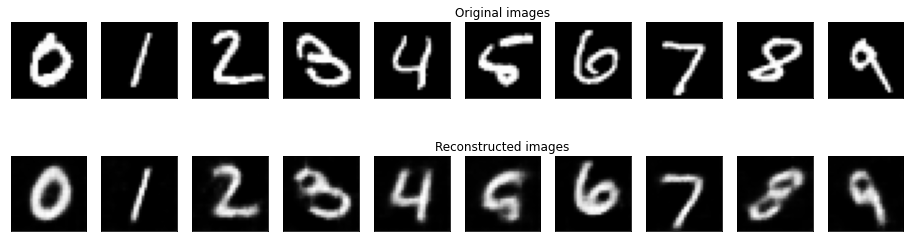

	 partial train loss (single batch): 0.025806
	 partial train loss (single batch): 0.025501
	 partial train loss (single batch): 0.026728
	 partial train loss (single batch): 0.028307
	 partial train loss (single batch): 0.024578
	 partial train loss (single batch): 0.025541
	 partial train loss (single batch): 0.026481
	 partial train loss (single batch): 0.026216
	 partial train loss (single batch): 0.027001
	 partial train loss (single batch): 0.027603
	 partial train loss (single batch): 0.025638
	 partial train loss (single batch): 0.027510
	 partial train loss (single batch): 0.026258
	 partial train loss (single batch): 0.026053
	 partial train loss (single batch): 0.027311
	 partial train loss (single batch): 0.025446
	 partial train loss (single batch): 0.025101
	 partial train loss (single batch): 0.025480
	 partial train loss (single batch): 0.025236
	 partial train loss (single batch): 0.025773
	 partial train loss (single batch): 0.027314
	 partial train loss (single batch

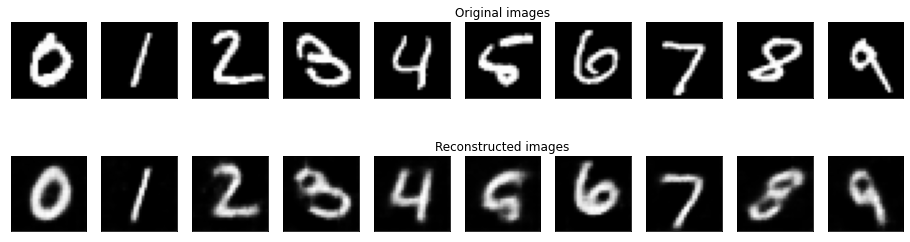

	 partial train loss (single batch): 0.025708
	 partial train loss (single batch): 0.025381
	 partial train loss (single batch): 0.026726
	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.024541
	 partial train loss (single batch): 0.025447
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.026942
	 partial train loss (single batch): 0.027551
	 partial train loss (single batch): 0.025538
	 partial train loss (single batch): 0.027395
	 partial train loss (single batch): 0.026206
	 partial train loss (single batch): 0.025998
	 partial train loss (single batch): 0.027262
	 partial train loss (single batch): 0.025395
	 partial train loss (single batch): 0.024988
	 partial train loss (single batch): 0.025316
	 partial train loss (single batch): 0.025211
	 partial train loss (single batch): 0.025718
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch

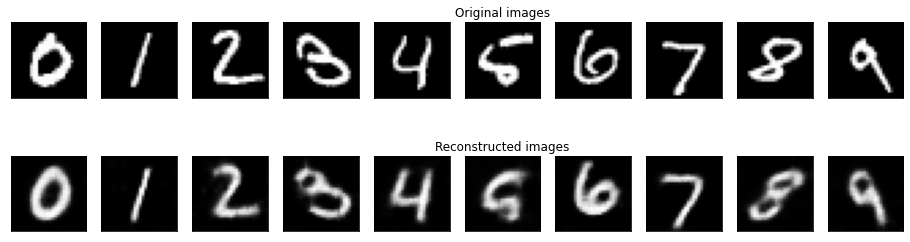

	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.025336
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch): 0.028099
	 partial train loss (single batch): 0.024405
	 partial train loss (single batch): 0.025299
	 partial train loss (single batch): 0.026261
	 partial train loss (single batch): 0.026043
	 partial train loss (single batch): 0.026833
	 partial train loss (single batch): 0.027453
	 partial train loss (single batch): 0.025476
	 partial train loss (single batch): 0.027306
	 partial train loss (single batch): 0.026208
	 partial train loss (single batch): 0.025993
	 partial train loss (single batch): 0.027210
	 partial train loss (single batch): 0.025289
	 partial train loss (single batch): 0.024890
	 partial train loss (single batch): 0.025234
	 partial train loss (single batch): 0.025141
	 partial train loss (single batch): 0.025596
	 partial train loss (single batch): 0.027170
	 partial train loss (single batch

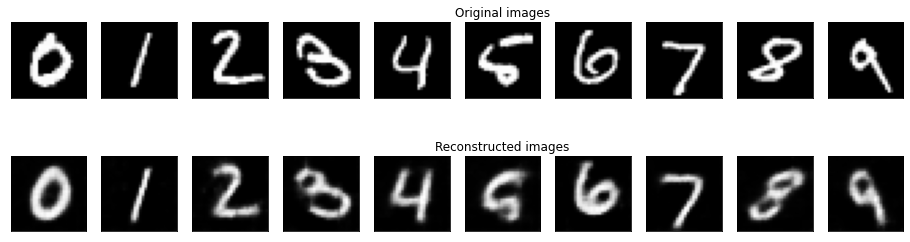

	 partial train loss (single batch): 0.025493
	 partial train loss (single batch): 0.025291
	 partial train loss (single batch): 0.026647
	 partial train loss (single batch): 0.027989
	 partial train loss (single batch): 0.024365
	 partial train loss (single batch): 0.025274
	 partial train loss (single batch): 0.026200
	 partial train loss (single batch): 0.025953
	 partial train loss (single batch): 0.026746
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.025441
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.026212
	 partial train loss (single batch): 0.025925
	 partial train loss (single batch): 0.027090
	 partial train loss (single batch): 0.025246
	 partial train loss (single batch): 0.024870
	 partial train loss (single batch): 0.025099
	 partial train loss (single batch): 0.025102
	 partial train loss (single batch): 0.025529
	 partial train loss (single batch): 0.027010
	 partial train loss (single batch

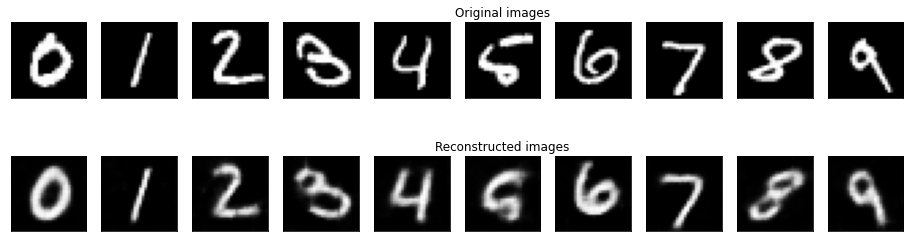

	 partial train loss (single batch): 0.025359
	 partial train loss (single batch): 0.025298
	 partial train loss (single batch): 0.026686
	 partial train loss (single batch): 0.027990
	 partial train loss (single batch): 0.024335
	 partial train loss (single batch): 0.025319
	 partial train loss (single batch): 0.026156
	 partial train loss (single batch): 0.025978
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.027371
	 partial train loss (single batch): 0.025474
	 partial train loss (single batch): 0.027198
	 partial train loss (single batch): 0.026198
	 partial train loss (single batch): 0.025999
	 partial train loss (single batch): 0.027085
	 partial train loss (single batch): 0.025280
	 partial train loss (single batch): 0.024949
	 partial train loss (single batch): 0.025021
	 partial train loss (single batch): 0.025145
	 partial train loss (single batch): 0.025562
	 partial train loss (single batch): 0.026909
	 partial train loss (single batch

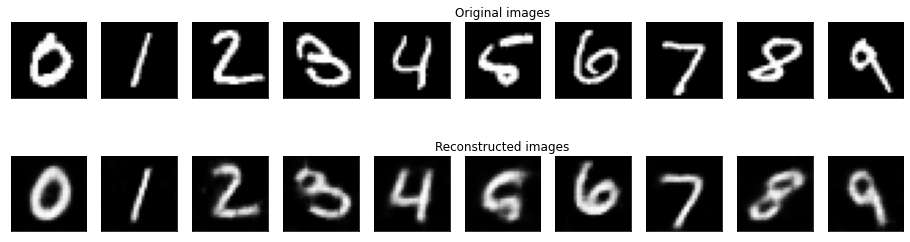

	 partial train loss (single batch): 0.025329
	 partial train loss (single batch): 0.025170
	 partial train loss (single batch): 0.026617
	 partial train loss (single batch): 0.027855
	 partial train loss (single batch): 0.024147
	 partial train loss (single batch): 0.025204
	 partial train loss (single batch): 0.026015
	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.026514
	 partial train loss (single batch): 0.027176
	 partial train loss (single batch): 0.025396
	 partial train loss (single batch): 0.027186
	 partial train loss (single batch): 0.026045
	 partial train loss (single batch): 0.025925
	 partial train loss (single batch): 0.026998
	 partial train loss (single batch): 0.025141
	 partial train loss (single batch): 0.024878
	 partial train loss (single batch): 0.024943
	 partial train loss (single batch): 0.025005
	 partial train loss (single batch): 0.025513
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch

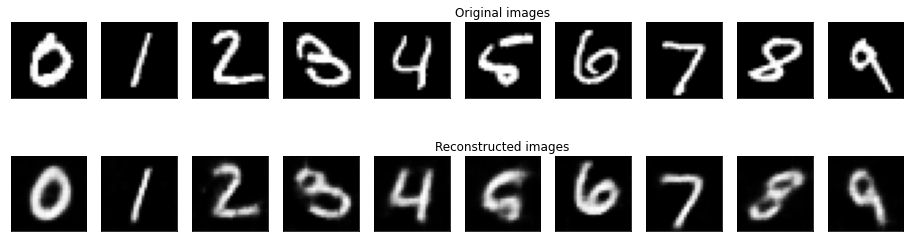

	 partial train loss (single batch): 0.025245
	 partial train loss (single batch): 0.025083
	 partial train loss (single batch): 0.026623
	 partial train loss (single batch): 0.027850
	 partial train loss (single batch): 0.024094
	 partial train loss (single batch): 0.025170
	 partial train loss (single batch): 0.026072
	 partial train loss (single batch): 0.025823
	 partial train loss (single batch): 0.026395
	 partial train loss (single batch): 0.027207
	 partial train loss (single batch): 0.025374
	 partial train loss (single batch): 0.027083
	 partial train loss (single batch): 0.025985
	 partial train loss (single batch): 0.025935
	 partial train loss (single batch): 0.026890
	 partial train loss (single batch): 0.024997
	 partial train loss (single batch): 0.024794
	 partial train loss (single batch): 0.024973
	 partial train loss (single batch): 0.024868
	 partial train loss (single batch): 0.025434
	 partial train loss (single batch): 0.026798
	 partial train loss (single batch

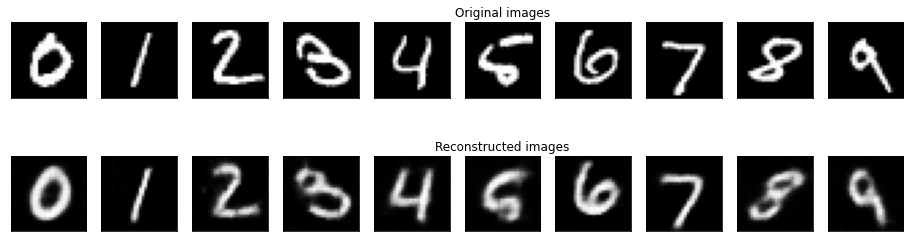

In [10]:
num_epochs = 15
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

Now the model is trained and we want to do a final evaluation on the test set。

In [11]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.026143917813897133

We can also observe how the reconstruction losses decrease over the epochs.

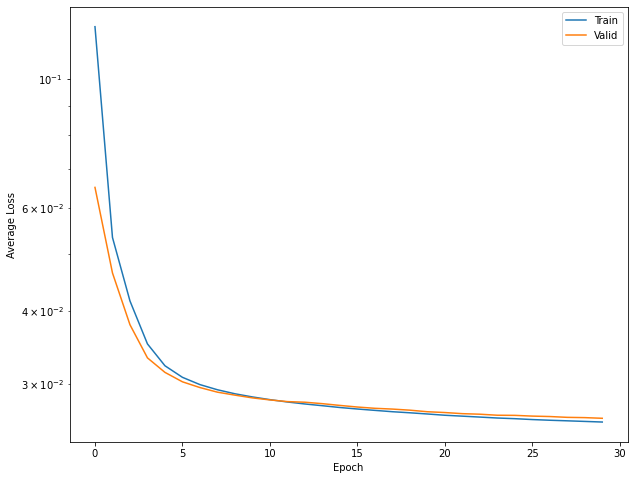

In [12]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

Generate new samples from the random latent code.

tensor([-0.1723,  0.1445,  0.0986, -0.0103])
tensor([0.5363, 0.7655, 0.6671, 0.5457])


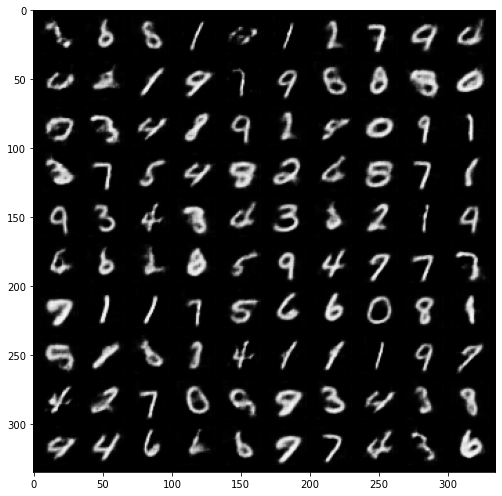

In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

Visualize the latent space with t-SNE.

In [17]:
encoded_samples = []
for sample in tqdm.tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:05<00:00, 1875.77it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-0.850128,2.167367,-0.455040,0.395525,7
1,1.669289,0.421334,1.225614,1.338227,2
2,0.789734,0.862211,-0.516070,0.222795,1
3,-0.427635,-0.770369,0.621228,-0.194699,0
4,-0.435537,-0.143774,-0.832548,-1.033872,4
...,...,...,...,...,...
9995,0.583692,-0.218961,1.733934,1.103339,2
9996,-0.112917,-0.111326,1.270136,-0.094088,3
9997,-0.171499,0.335437,-1.102203,-0.262083,4
9998,-0.360887,-0.491628,-0.245829,0.664920,5


In [ ]:
# Let’s plot the latent space representation using plotly express library:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)